In [ ]:
#!pip install torch
#!pip install transformers
#!pip install seaborn

In [1]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import (
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    squad_convert_examples_to_features)

from transformers.data.processors.squad import SquadResult, SquadV2Processor, SquadExample
from transformers.data.metrics.squad_metrics import compute_predictions_logits
from transformers.pipelines import pipeline


import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#define a function to load the images
def load_text_data(folder_path):
    text_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                text_data.append(text)
    return text_data

# Replace 'folder_path' with the path to your folder containing documents
folder_path = "C:/Users/omuku/OneDrive/Desktop/Capstone Project/CUAD_v1/full_contract_txt"
contracts = load_text_data(folder_path)

In [3]:
model_path="C:/Users/omuku/OneDrive/Desktop/Capstone Project/Cuad Models/roberta-base"

In [4]:
#load the model and tokenizer
#tokenizer prepares the inputs for a model
model = AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

In [5]:
#load the queries and sample contract to test the model
with open('C:/Users/omuku/OneDrive/Desktop/Capstone Project/CUAD_v1/CUAD_v1.json') as json_file:
    data = json.load(json_file)
    
question = data['data'][0]['paragraphs'][0]['qas'][3]['question']
paragraph = ' '.join(data['data'][0]['paragraphs'][0]['context'].split()[:150])

The code above loads the forth query "What is the date when the contract is effective?" of the first contract, displaying the first 150 words of the contract.

In [6]:
print(question)

Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective 


In [7]:
print(paragraph)

EXHIBIT 10.6 DISTRIBUTOR AGREEMENT THIS DISTRIBUTOR AGREEMENT (the "Agreement") is made by and between Electric City Corp., a Delaware corporation ("Company") and Electric City of Illinois LLC ("Distributor") this 7th day of September, 1999. RECITALS A. The Company's Business. The Company is presently engaged in the business of selling an energy efficiency device, which is referred to as an "Energy Saver" which may be improved or otherwise changed from its present composition (the "Products"). The Company may engage in the business of selling other products or other devices other than the Products, which will be considered Products if Distributor exercises its options pursuant to Section 7 hereof. B. Representations. As an inducement to the Company to enter into this Agreement, the Distributor has represented that it has or will have the facilities, personnel, and financial capability to promote the sale and use of Products. As an inducement to Distributor to


**First Prediction**

The question and the contract are concantated, tokenized and then fed into the model which then provide two outputs:start logits and end logits
                                 

In [8]:
# concatenates & encodes question and paragraph
encoding = tokenizer.encode_plus(text=question, text_pair=paragraph)

# extracts the embeddings for model prediction
inputs = encoding['input_ids']

# get the tokens
tokens = tokenizer.convert_ids_to_tokens(inputs)

# make model prediction
outputs = model(input_ids=torch.tensor([inputs]))

# get the start and end logits
start_scores = outputs.start_logits
end_scores = outputs.end_logits

**Plot charts for the probabilities for each token in contract- start and end tokens**

C:\Users\omuku\AppData\Local\Temp\ipykernel_4136\1124267073.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


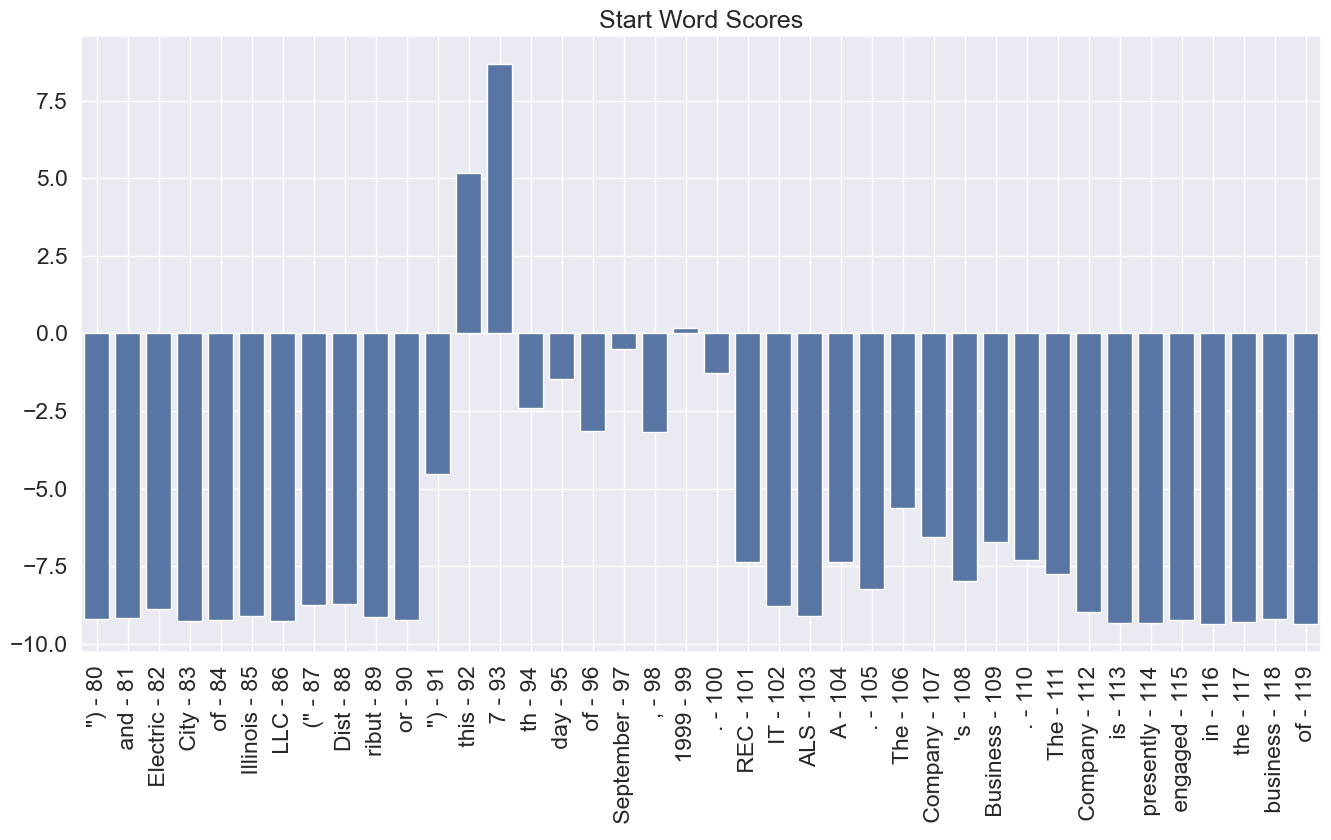

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

#use the tokens as the x-axis labels.
# to be unique,add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(tokenizer.convert_tokens_to_string(token), i))

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels[80:120], y=s_scores[80:120], errorbar=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

C:\Users\omuku\AppData\Local\Temp\ipykernel_4136\1309760404.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


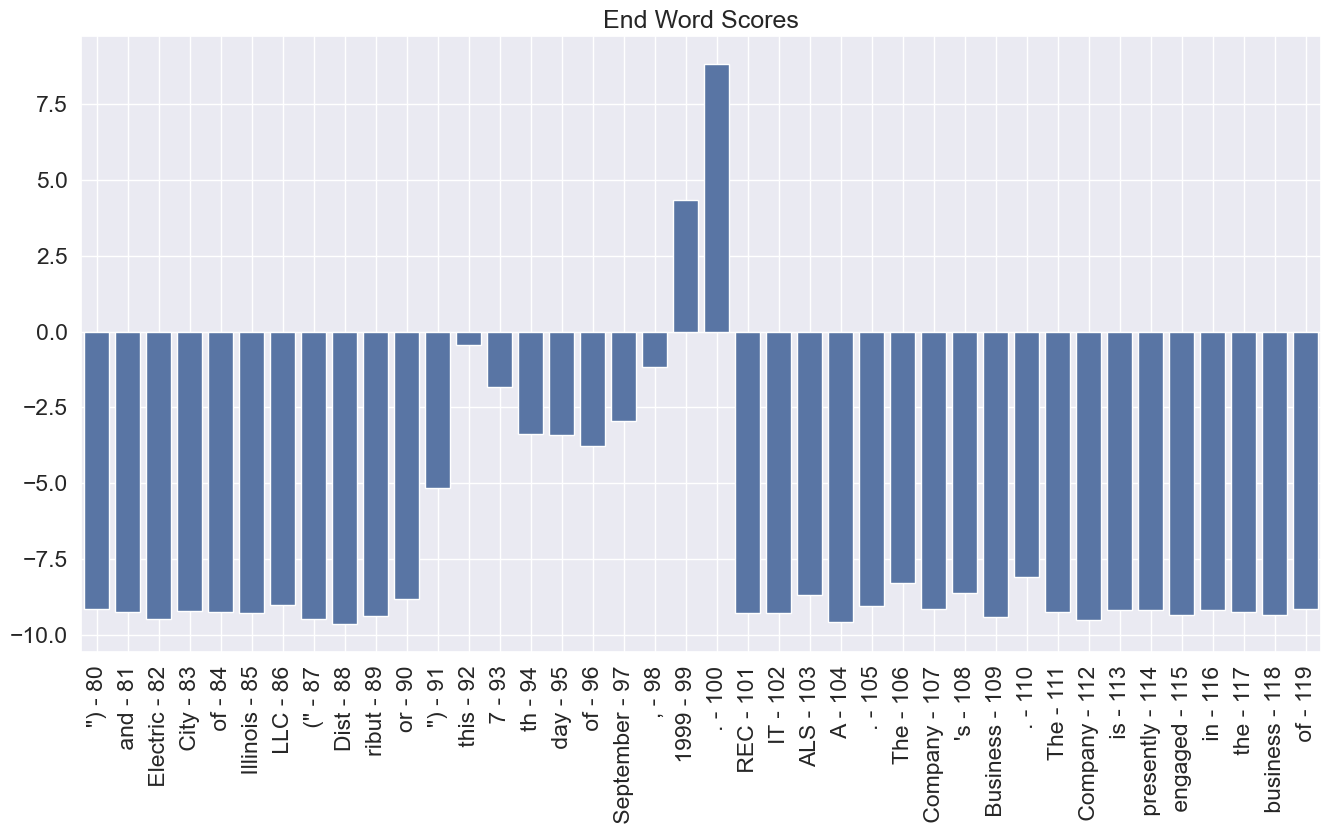

In [10]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels[80:120], y=e_scores[80:120], errorbar=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [11]:
# retrieve start & end tokens with the highest probability
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)

# retrieve the answer predicted by the model
answer = tokenizer.convert_tokens_to_string(tokens[start_index:end_index+1]).strip()
print(answer.strip())

7th day of September, 1999.


The NLP model used have a limit of 512 tokens, meaning the model cannot scan the entire information in the contract.
The contracts in the dataset only about 2.4% are shorter than 514 words.Thus most contracts will run into word limit.

In [12]:
import json
from transformers import AutoTokenizer

with open('C:/Users/omuku/OneDrive/Desktop/Capstone Project/CUAD_v1/CUAD_v1.json') as json_file:
    data = json.load(json_file)

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
    
l = []
for i, x in enumerate(data['data']):
    l.append(len(tokenizer.encode(data['data'][i]['paragraphs'][0]['context'])))

print(f"Contracts with token length < 512: {sum(1 for x in l if x < 512) / len(l) * 100:.1f}%")


Token indices sequence length is longer than the specified maximum sequence length for this model (23250 > 512). Running this sequence through the model will result in indexing errors


Contracts with token length < 512: 2.4%


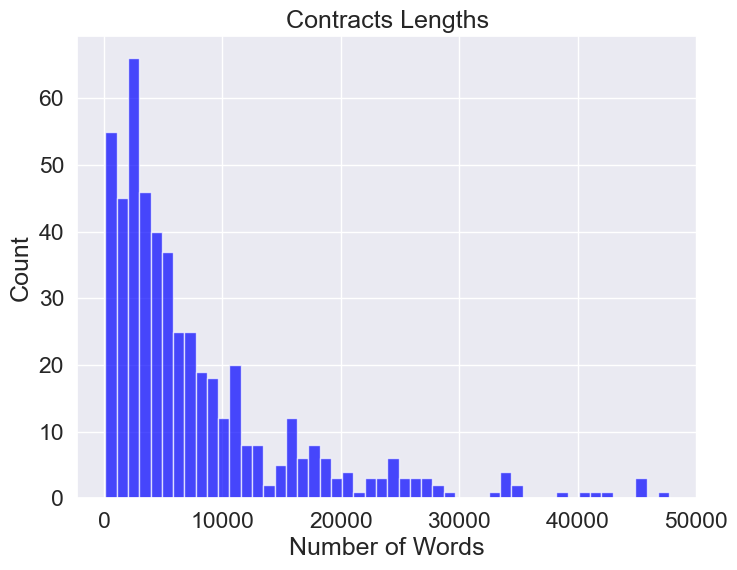

In [13]:
#plot a histogram
def document_length(text):
    return len(text.split())


# Assuming 'loaded_data' is a list of text data
document_lengths = [len(text.split()) for text in contracts]

# Plot the distribution of document lengths for train_data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(document_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Contracts Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

**Overcoming 512 Word Limitation**

A contract is split up into several parts of 512 words. The model can then analyse each part individually and aggregate the results to derive a final prediction.

In [14]:
# define a prediction function
def prediction(question_texts, context_text, model_path):
    # set the parameters
    max_seq_length = 512
    doc_stride = 256
    n_best_size = 1
    max_query_length = 64
    max_answer_length = 512
    do_lower_case = False
    null_score_diff_threshold = 0.0

    def to_list(tensor):
        return tensor.detach().cpu().tolist()

    config_class, model_class, tokenizer_class = (AutoConfig, AutoModelForQuestionAnswering,
                                                  AutoTokenizer)
    config = config_class.from_pretrained(model_path)
    tokenizer = tokenizer_class.from_pretrained(model_path, do_lower_case=True, use_fast=False)
    model = model_class.from_pretrained(model_path, config=config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    processor = SquadV2Processor()
    examples = []

    for i, question_text in enumerate(question_texts):
        example = SquadExample(qas_id=str(i),question_text=question_text,context_text=context_text,
                               answer_text=None,start_position_character=None,title="Predict",answers=None,)

        examples.append(example)

    features, dataset = squad_convert_examples_to_features(examples=examples,tokenizer=tokenizer,max_seq_length=max_seq_length,
                                                           doc_stride=doc_stride,max_query_length=max_query_length,is_training=False,
                                                           return_dataset="pt",threads=1,)

    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=10)
    all_results = []

    for batch in eval_dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
            }

            example_indices = batch[3]

            outputs = model(**inputs)

            for i, example_index in enumerate(example_indices):
                eval_feature = features[example_index.item()]
                unique_id = int(eval_feature.unique_id)

                output = [to_list(output[i]) for output in outputs.to_tuple()]

                start_logits, end_logits = output
                result = SquadResult(unique_id, start_logits, end_logits)
                all_results.append(result)

    final_predictions = compute_predictions_logits(all_examples=examples,all_features=features,all_results=all_results,
                                                   n_best_size=n_best_size,max_answer_length=max_answer_length,do_lower_case=do_lower_case,
                                                   output_prediction_file=None,output_nbest_file=None,output_null_log_odds_file=None,
                                                   verbose_logging=False,version_2_with_negative=True,
                                                   null_score_diff_threshold=null_score_diff_threshold,tokenizer=tokenizer)

    return final_predictions

**Testing the prediction**

In [15]:
# get the list of questions
questions = []
for i, q in enumerate(data['data'][0]['paragraphs'][0]['qas']):
    question = data['data'][0]['paragraphs'][0]['qas'][i]['question']
    questions.append(question)
contract = data['data'][0]['paragraphs'][0]['context']

In [16]:
# first 5 questions
print('\n'.join(map(str, questions[:5])))

Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract
Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract
Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract
Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective 
Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?


In [17]:
output_path = "C:/Users/omuku/OneDrive/Desktop/Capstone Project/Output"
output_file_path = "C:/Users/omuku/OneDrive/Desktop/Capstone Project/Output/questions.txt"

# Open the file in write mode
with open(output_file_path, 'w') as output_file:
    # Iterate through questions and write each question to a new line
    for question in questions:
        output_file.write(str(question) + '\n')

print(f"Questions saved to {output_file_path}")

Questions saved to C:/Users/omuku/OneDrive/Desktop/Capstone Project/Output/questions.txt


In [ ]:
# prediction on the first contract
predictions = prediction(questions, contracts[0], model_path)

In [ ]:
#print(predictions)

In [ ]:
#save the predictions
output_file_path = os.path.join(output_path, "predictions.txt")

# Open the file in write mode
with open(output_file_path, 'w') as output_file:
    # Iterate through predictions and write each prediction to a new line
    for prediction in predictions:
        output_file.write(str(prediction) + '\n')

print(f"Predictions saved to {output_file_path}")


In [ ]:
with open('Output/predictions.txt', 'w') as f:
    for i, p in enumerate(predictions):
        f.write(f"Question {i+1}: {questions[int(p)]}\nAnswer: {predictions[p]}\n\n")